In [1]:
from ple.games.flappybird import FlappyBird
from ple import PLE
import matplotlib.pyplot as plt
import os
import numpy as np
import tensorflow as tf

%matplotlib inline
os.environ["SDL_VIDEODRIVER"] = "dummy"  # this line make pop-out window not appear
game = FlappyBird()
env = PLE(game, fps=30, display_screen=False)  # environment interface to game
env.reset_game()

pygame 1.9.6
Hello from the pygame community. https://www.pygame.org/contribute.html
couldn't import doomish
Couldn't import doom


In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Restrict TensorFlow to only use the fourth GPU
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')

        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

2 Physical GPUs, 1 Logical GPUs


In [3]:
# return a dictionary whose key is action description and value is action index
print(game.actions)
# return a list of action index (include None)
print(env.getActionSet())

{'up': 119}
[119, None]


In [4]:
# a dictionary describe state
'''
    player y position.
    players velocity.
    next pipe distance to player
    next pipe top y position
    next pipe bottom y position
    next next pipe distance to player
    next next pipe top y position
    next next pipe bottom y position
'''
game.getGameState()

{'player_y': 256,
 'player_vel': 0,
 'next_pipe_dist_to_player': 309.0,
 'next_pipe_top_y': 144,
 'next_pipe_bottom_y': 244,
 'next_next_pipe_dist_to_player': 453.0,
 'next_next_pipe_top_y': 160,
 'next_next_pipe_bottom_y': 260}

In [5]:
import math
import copy
from collections import defaultdict
MIN_EXPLORING_RATE = 0.01
MIN_LEARNING_RATE = 0.5


class Agent:

    def __init__(self,
                 bucket_range_per_feature,
                 num_action,
                 t=0,
                 discount_factor=0.99):
        self.update_parameters(t)  # init explore rate and learning rate
        self.q_table = defaultdict(lambda: np.zeros(num_action))
        self.discount_factor = discount_factor
        self.num_action = num_action

        # how to discretize each feature in a state
        # the higher each value, less time to train but with worser performance
        # e.g. if range = 2, feature with value 1 is equal to feature with value 0 bacause int(1/2) = int(0/2)
        self.bucket_range_per_feature = bucket_range_per_feature

    def select_action(self, state):
        # epsilon-greedy
        state_idx = self.get_state_idx(state)
        if np.random.rand() < self.exploring_rate:
            action = np.random.choice(num_action)  # Select a random action
        else:
            action = np.argmax(
                self.q_table[state_idx])  # Select the action with the highest q
        return action

    def update_policy(self, state, action, reward, state_prime):
        state_idx = self.get_state_idx(state)
        state_prime_idx = self.get_state_idx(state_prime)
        # Update Q_value using Q-learning update rule
        action_prime = self.select_action(state_prime)
        q = self.q_table[state_prime_idx][action_prime]
        
        self.q_table[state_idx][action] += self.learning_rate * (
            reward + self.discount_factor * q - self.q_table[state_idx][action])
        
        return action_prime

    def get_state_idx(self, state):
        # instead of using absolute position of pipe, use relative position
        state = copy.deepcopy(state)
        state['next_next_pipe_bottom_y'] -= state['player_y']
        state['next_next_pipe_top_y'] -= state['player_y']
        state['next_pipe_bottom_y'] -= state['player_y']
        state['next_pipe_top_y'] -= state['player_y']

        # sort to make list converted from dict ordered in alphabet order
        state_key = [k for k, v in sorted(state.items())]

        # do bucketing to decrease state space to speed up training
        state_idx = []
        for key in state_key:
            state_idx.append(
                int(state[key] / self.bucket_range_per_feature[key]))
        return tuple(state_idx)

    def update_parameters(self, episode):
        self.exploring_rate = max(MIN_EXPLORING_RATE,
                                  min(0.5, 0.99**((episode) / 30)))
        self.learning_rate = max(MIN_LEARNING_RATE, min(0.5, 0.99
                                                        ** ((episode) / 30)))

    def shutdown_explore(self):
        # make action selection greedy
        self.exploring_rate = 0

In [6]:
num_action = len(env.getActionSet())
bucket_range_per_feature = {
  'next_next_pipe_bottom_y': 40,
  'next_next_pipe_dist_to_player': 512,
  'next_next_pipe_top_y': 40,
  'next_pipe_bottom_y': 20,
  'next_pipe_dist_to_player': 20,
  'next_pipe_top_y': 20,
  'player_vel': 4,
  'player_y': 16
}
# init agent
agent = Agent(bucket_range_per_feature, num_action)

In [7]:
import moviepy.editor as mpy


def make_anim(images, fps=60, true_image=False):
    duration = len(images) / fps

    def make_frame(t):
        try:
            x = images[int(len(images) / duration * t)]
        except:
            x = images[-1]

        if true_image:
            return x.astype(np.uint8)
        else:
            return ((x + 1) / 2 * 255).astype(np.uint8)

    clip = mpy.VideoClip(make_frame, duration=duration)
    clip.fps = fps
    return clip

In [8]:
from IPython.display import Image, display

reward_per_epoch = []
lifetime_per_epoch = []
exploring_rates = []
learning_rates = []
print_every_episode = 500
show_gif_every_episode = 5000
NUM_EPISODE = 40000
for episode in range(0, NUM_EPISODE):

    # Reset the environment
    env.reset_game()

    # record frame
    frames = [env.getScreenRGB()]

    # for every 500 episodes, shutdown exploration to see performance of greedy action
    if episode % print_every_episode == 0:
        agent.shutdown_explore()

    # the initial state
    state = game.getGameState()
    # cumulate reward for this episode
    cum_reward = 0  
    t = 0

    # select an action
    action = agent.select_action(state)
    
    while not env.game_over():
        
        # execute the action and get reward
        # reward = +1 when pass a pipe, -5 when die
        reward = env.act(env.getActionSet()[action])  

        frames.append(env.getScreenRGB())

        # cumulate reward
        cum_reward += reward

        # observe the result
        state_prime = game.getGameState()  # get next state

        # update agent
        action_prime = agent.update_policy(state, action, reward, state_prime)

        # Setting up for the next iteration
        state = state_prime
        action = action_prime
        t += 1

    # update exploring_rate and learning_rate
    agent.update_parameters(episode)

    if episode % print_every_episode == 0:
        print("Episode %d finished after %f time steps" % (episode, t))
        print("cumulated reward: %f" % cum_reward)
        print("exploring rate %f" % agent.exploring_rate)
        print("learning rate %f" % agent.learning_rate)
        reward_per_epoch.append(cum_reward)
        exploring_rates.append(agent.exploring_rate)
        learning_rates.append(agent.learning_rate)
        lifetime_per_epoch.append(t)

    # for every 5000 episode, record an animation
    if episode % show_gif_every_episode == 0:
        print("len frames:", len(frames))
        clip = make_anim(frames, fps=60, true_image=True).rotate(-90)
        display(clip.ipython_display(fps=60, autoplay=1, loop=1))

Episode 0 finished after 62.000000 time steps
cumulated reward: -5.000000
exploring rate 0.500000
learning rate 0.500000
len frames: 63
Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4

Moviepy - Done !
Moviepy - video ready __temp__.mp4


Episode 500 finished after 62.000000 time steps
cumulated reward: -5.000000
exploring rate 0.500000
learning rate 0.500000
Episode 1000 finished after 62.000000 time steps
cumulated reward: -5.000000
exploring rate 0.500000
learning rate 0.500000
Episode 1500 finished after 62.000000 time steps
cumulated reward: -5.000000
exploring rate 0.500000
learning rate 0.500000
Episode 2000 finished after 62.000000 time steps
cumulated reward: -5.000000
exploring rate 0.500000
learning rate 0.500000
Episode 2500 finished after 62.000000 time steps
cumulated reward: -5.000000
exploring rate 0.432779
learning rate 0.500000
Episode 3000 finished after 62.000000 time steps
cumulated reward: -5.000000
exploring rate 0.366032
learning rate 0.500000
Episode 3500 finished after 62.000000 time steps
cumulated reward: -5.000000
exploring rate 0.309580
learning rate 0.500000
Episode 4000 finished after 68.000000 time steps
cumulated reward: -4.000000
exploring rate 0.261834
learning rate 0.500000
Episode 4

Episode 5000 finished after 62.000000 time steps
cumulated reward: -5.000000
exploring rate 0.187298
learning rate 0.500000
len frames: 63
Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4

Moviepy - Done !
Moviepy - video ready __temp__.mp4


Episode 5500 finished after 64.000000 time steps
cumulated reward: -5.000000
exploring rate 0.158411
learning rate 0.500000
Episode 6000 finished after 67.000000 time steps
cumulated reward: -4.000000
exploring rate 0.133980
learning rate 0.500000
Episode 6500 finished after 71.000000 time steps
cumulated reward: -4.000000
exploring rate 0.113316
learning rate 0.500000
Episode 7000 finished after 62.000000 time steps
cumulated reward: -5.000000
exploring rate 0.095840
learning rate 0.500000
Episode 7500 finished after 98.000000 time steps
cumulated reward: -4.000000
exploring rate 0.081059
learning rate 0.500000
Episode 8000 finished after 68.000000 time steps
cumulated reward: -4.000000
exploring rate 0.068557
learning rate 0.500000
Episode 8500 finished after 98.000000 time steps
cumulated reward: -4.000000
exploring rate 0.057984
learning rate 0.500000
Episode 9000 finished after 148.000000 time steps
cumulated reward: -2.000000
exploring rate 0.049041
learning rate 0.500000
Episode

Episode 10000 finished after 62.000000 time steps
cumulated reward: -5.000000
exploring rate 0.035080
learning rate 0.500000
len frames: 63
Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4

Moviepy - Done !
Moviepy - video ready __temp__.mp4


Episode 10500 finished after 98.000000 time steps
cumulated reward: -4.000000
exploring rate 0.029670
learning rate 0.500000
Episode 11000 finished after 98.000000 time steps
cumulated reward: -4.000000
exploring rate 0.025094
learning rate 0.500000
Episode 11500 finished after 98.000000 time steps
cumulated reward: -4.000000
exploring rate 0.021224
learning rate 0.500000
Episode 12000 finished after 72.000000 time steps
cumulated reward: -4.000000
exploring rate 0.017951
learning rate 0.500000
Episode 12500 finished after 134.000000 time steps
cumulated reward: -3.000000
exploring rate 0.015182
learning rate 0.500000
Episode 13000 finished after 126.000000 time steps
cumulated reward: -3.000000
exploring rate 0.012841
learning rate 0.500000
Episode 13500 finished after 134.000000 time steps
cumulated reward: -3.000000
exploring rate 0.010860
learning rate 0.500000
Episode 14000 finished after 98.000000 time steps
cumulated reward: -4.000000
exploring rate 0.010000
learning rate 0.5000

Episode 15000 finished after 76.000000 time steps
cumulated reward: -4.000000
exploring rate 0.010000
learning rate 0.500000
len frames: 77
Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4

Moviepy - Done !
Moviepy - video ready __temp__.mp4


Episode 15500 finished after 134.000000 time steps
cumulated reward: -3.000000
exploring rate 0.010000
learning rate 0.500000
Episode 16000 finished after 76.000000 time steps
cumulated reward: -4.000000
exploring rate 0.010000
learning rate 0.500000
Episode 16500 finished after 211.000000 time steps
cumulated reward: -1.000000
exploring rate 0.010000
learning rate 0.500000
Episode 17000 finished after 62.000000 time steps
cumulated reward: -5.000000
exploring rate 0.010000
learning rate 0.500000
Episode 17500 finished after 165.000000 time steps
cumulated reward: -2.000000
exploring rate 0.010000
learning rate 0.500000
Episode 18000 finished after 183.000000 time steps
cumulated reward: -1.000000
exploring rate 0.010000
learning rate 0.500000
Episode 18500 finished after 258.000000 time steps
cumulated reward: 1.000000
exploring rate 0.010000
learning rate 0.500000
Episode 19000 finished after 62.000000 time steps
cumulated reward: -5.000000
exploring rate 0.010000
learning rate 0.500

Episode 20000 finished after 72.000000 time steps
cumulated reward: -4.000000
exploring rate 0.010000
learning rate 0.500000
len frames: 73
Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4

Moviepy - Done !
Moviepy - video ready __temp__.mp4


Episode 20500 finished after 97.000000 time steps
cumulated reward: -4.000000
exploring rate 0.010000
learning rate 0.500000
Episode 21000 finished after 301.000000 time steps
cumulated reward: 2.000000
exploring rate 0.010000
learning rate 0.500000
Episode 21500 finished after 357.000000 time steps
cumulated reward: 3.000000
exploring rate 0.010000
learning rate 0.500000
Episode 22000 finished after 247.000000 time steps
cumulated reward: 0.000000
exploring rate 0.010000
learning rate 0.500000
Episode 22500 finished after 812.000000 time steps
cumulated reward: 15.000000
exploring rate 0.010000
learning rate 0.500000
Episode 23000 finished after 562.000000 time steps
cumulated reward: 9.000000
exploring rate 0.010000
learning rate 0.500000
Episode 23500 finished after 71.000000 time steps
cumulated reward: -4.000000
exploring rate 0.010000
learning rate 0.500000
Episode 24000 finished after 98.000000 time steps
cumulated reward: -4.000000
exploring rate 0.010000
learning rate 0.500000

t:   5%|▍         | 48/1039 [00:00<00:02, 475.62it/s, now=None]

Episode 25000 finished after 1038.000000 time steps
cumulated reward: 21.000000
exploring rate 0.010000
learning rate 0.500000
len frames: 1039
Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


Episode 25500 finished after 473.000000 time steps
cumulated reward: 6.000000
exploring rate 0.010000
learning rate 0.500000
Episode 26000 finished after 586.000000 time steps
cumulated reward: 9.000000
exploring rate 0.010000
learning rate 0.500000
Episode 26500 finished after 436.000000 time steps
cumulated reward: 5.000000
exploring rate 0.010000
learning rate 0.500000
Episode 27000 finished after 446.000000 time steps
cumulated reward: 6.000000
exploring rate 0.010000
learning rate 0.500000
Episode 27500 finished after 437.000000 time steps
cumulated reward: 5.000000
exploring rate 0.010000
learning rate 0.500000
Episode 28000 finished after 145.000000 time steps
cumulated reward: -2.000000
exploring rate 0.010000
learning rate 0.500000
Episode 28500 finished after 288.000000 time steps
cumulated reward: 1.000000
exploring rate 0.010000
learning rate 0.500000
Episode 29000 finished after 142.000000 time steps
cumulated reward: -2.000000
exploring rate 0.010000
learning rate 0.50000

t:   3%|▎         | 48/1568 [00:00<00:03, 472.58it/s, now=None]

Episode 30000 finished after 1567.000000 time steps
cumulated reward: 35.000000
exploring rate 0.010000
learning rate 0.500000
len frames: 1568
Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


Episode 30500 finished after 473.000000 time steps
cumulated reward: 6.000000
exploring rate 0.010000
learning rate 0.500000
Episode 31000 finished after 338.000000 time steps
cumulated reward: 3.000000
exploring rate 0.010000
learning rate 0.500000
Episode 31500 finished after 853.000000 time steps
cumulated reward: 16.000000
exploring rate 0.010000
learning rate 0.500000
Episode 32000 finished after 1655.000000 time steps
cumulated reward: 38.000000
exploring rate 0.010000
learning rate 0.500000
Episode 32500 finished after 1151.000000 time steps
cumulated reward: 24.000000
exploring rate 0.010000
learning rate 0.500000
Episode 33000 finished after 889.000000 time steps
cumulated reward: 17.000000
exploring rate 0.010000
learning rate 0.500000
Episode 33500 finished after 87.000000 time steps
cumulated reward: -4.000000
exploring rate 0.010000
learning rate 0.500000
Episode 34000 finished after 3827.000000 time steps
cumulated reward: 95.000000
exploring rate 0.010000
learning rate 0

t:   4%|▍         | 48/1265 [00:00<00:02, 476.46it/s, now=None]

Episode 35000 finished after 1264.000000 time steps
cumulated reward: 27.000000
exploring rate 0.010000
learning rate 0.500000
len frames: 1265
Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


Episode 35500 finished after 1454.000000 time steps
cumulated reward: 32.000000
exploring rate 0.010000
learning rate 0.500000
Episode 36000 finished after 629.000000 time steps
cumulated reward: 10.000000
exploring rate 0.010000
learning rate 0.500000
Episode 36500 finished after 473.000000 time steps
cumulated reward: 6.000000
exploring rate 0.010000
learning rate 0.500000
Episode 37000 finished after 2631.000000 time steps
cumulated reward: 64.000000
exploring rate 0.010000
learning rate 0.500000
Episode 37500 finished after 773.000000 time steps
cumulated reward: 14.000000
exploring rate 0.010000
learning rate 0.500000
Episode 38000 finished after 437.000000 time steps
cumulated reward: 5.000000
exploring rate 0.010000
learning rate 0.500000
Episode 38500 finished after 437.000000 time steps
cumulated reward: 5.000000
exploring rate 0.010000
learning rate 0.500000
Episode 39000 finished after 272.000000 time steps
cumulated reward: 1.000000
exploring rate 0.010000
learning rate 0.5

In [9]:
def demo():
    # Reset the environment
    env.reset_game()

    # record frame
    frames = [env.getScreenRGB()]

    # shutdown exploration to see performance of greedy action
    agent.shutdown_explore()

    # the initial state
    state = game.getGameState()

    while not env.game_over():
        # select an action
        action = agent.select_action(state)

        # execute the action and get reward
        reward = env.act(env.getActionSet()[action])

        frames.append(env.getScreenRGB())

        # observe the result
        state_prime = game.getGameState()  # get next state

        # Setting up for the next iteration
        state = state_prime

    clip = make_anim(frames, fps=60, true_image=True).rotate(-90)
    display(clip.ipython_display(fps=60, autoplay=1, loop=1))


demo()

t:   6%|▋         | 48/753 [00:00<00:01, 477.05it/s, now=None]

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


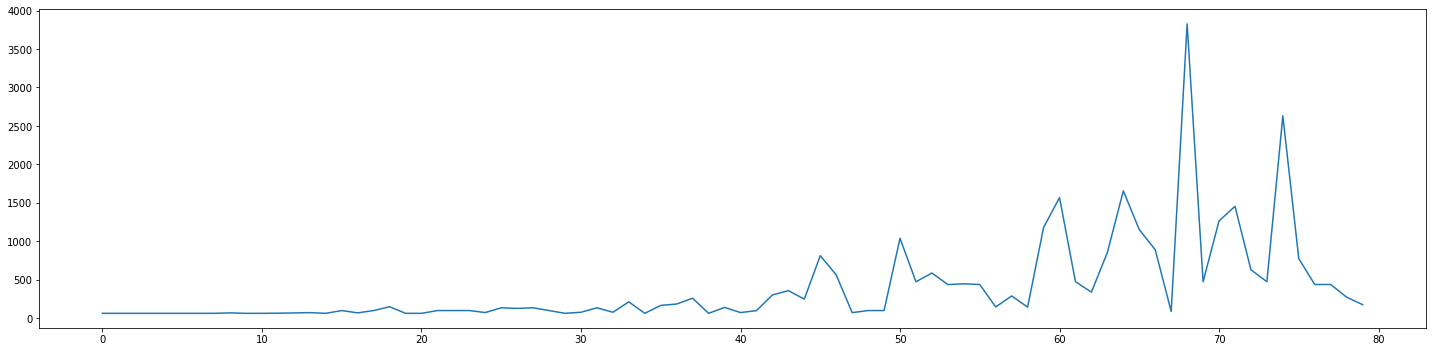

In [10]:
# plot life time against training episodes
fig, ax1 = plt.subplots(figsize=(20, 5))
plt.plot(range(len(lifetime_per_epoch)), lifetime_per_epoch)
fig.tight_layout()
plt.show()

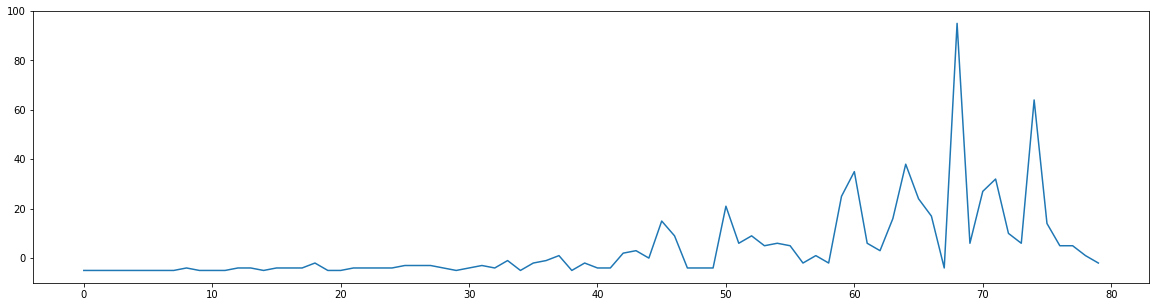

In [11]:
# plot reward against training episodes
fig, ax1 = plt.subplots(figsize=(20, 5))
plt.plot(range(len(reward_per_epoch)), reward_per_epoch)
plt.show()

---
---
<font style="font-size:15px; font-family:Comic Sans MS;">
Based on the game result, I found that:
</font>
<br><br>
<font style="font-size:15px; font-family:Comic Sans MS;">
1.The highest score achieved by using Q-Learning seens be a little bit higher than the highest score achieved by using SARSA.
</font>
<br><br>
<font style="font-size:15px; font-family:Comic Sans MS;">
2.Q-Learning might achieve some score on the earlier epoch values (around 25 to 32), while the SARSA is more stable which means its scores are just around 0 on the earlier epoch values.
</font>
<br><br>
<font style="font-size:15px; font-family:Comic Sans MS;">
3.Q-Learning would still get less than 0 mark on the late stage of epoch value while the SARSA will atleast try to maintain the score it achieved above or equal to 0.
</font>